# Testing Variations in Pooling Type

## Setup and configuration

**Initial setup:** data is pulled from Kaggle, follow the steps below to get that set up.

1.   You'll need to upload your `kaggle.json` (Kaggle Website > Account > API > Create New API Token) to the working directory.

2.   Comment out the below code block after your first run to prevent re-downloading data for no reason.

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download grassknoted/asl-alphabet --unzip

**Optional:** comment out the code block below if you would like to see Tensorflow logs.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

**Optional:** comment out the code block below if you want to see warnings.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Force Google Colab to use latest version of Tensorflow to avoid miscellaneous issues.

In [ ]:
!pip install tensorflow -U

Other imports.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import os

from IPython.display import Markdown
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Model creation


### Load and preprocess data

Create training and validation datasets.

In [ ]:
batch_size = 64
image_size = 64

train_dir = './asl_alphabet_train/asl_alphabet_train'

train_ds, test_val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.4,
  subset="both",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

num_classes = len(train_ds.class_names)

Found 87000 files belonging to 29 classes.
Using 52200 files for training.
Using 34800 files for validation.


In [ ]:
test_ds, val_ds = train_test_split(
  list(test_val_ds.unbatch().as_numpy_iterator()), 
  train_size=0.5, 
  random_state=123
)

print(f'Using {len(test_ds)} files for testing.')
print(f'Using {len(val_ds)} files for validation.')

test_ds = np.array(test_ds).transpose().tolist()
val_ds = np.array(val_ds).transpose().tolist()

test_ds = tf.data.Dataset.from_tensor_slices((test_ds[0], test_ds[1])).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_ds[0], val_ds[1])).batch(batch_size)

Using 17400 files for testing.
Using 17400 files for validation.


### Create and fit models

Multiple models are created with varying pooling types.

In [ ]:
from keras import layers
from keras import backend as K

class MinPooling2D(layers.MaxPooling2D):


  def __init__(self, pool_size=(2, 2), strides=None, 
               padding='valid', data_format=None, **kwargs):
    super(tf.keras.layers.MaxPooling2D(), self).__init__(pool_size, strides, padding,
                                       data_format, **kwargs)

  def pooling_function(inputs, pool_size, strides, padding, data_format):
    return -K.pool2d(-inputs, pool_size, strides, padding, data_format,
                                                         pool_mode='max')

In [ ]:
model_data = []


max_layers = [
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
]

avg_layers = [
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(), 
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
]

min_layers = [
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
]

for idx, layers in enumerate([max_layers, avg_layers]):
  model = tf.keras.Sequential(layers)

  name = 'unset'
  if idx == 0:
    name = 'max pooling'
  elif idx == 1:
    name = 'avg pooling'
  elif idx == 2:
    name = 'min pooling'

  model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
  )

  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
  
  model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop],
    verbose=1 # set to 1 or 2 for reporting
  )

  model_data.append({
    "model": model,
    "pooling_layer": name,
    "metrics": pd.DataFrame(model.history.history)
  })

Epoch 1/50
816/816 [==============================] - 13s 15ms/step - loss: 1.2527 - accuracy: 0.6258 - val_loss: 0.3781 - val_accuracy: 0.8725
Epoch 2/50
816/816 [==============================] - 12s 15ms/step - loss: 0.2062 - accuracy: 0.9326 - val_loss: 0.1266 - val_accuracy: 0.9621
Epoch 3/50
816/816 [==============================] - 13s 15ms/step - loss: 0.0911 - accuracy: 0.9711 - val_loss: 0.1115 - val_accuracy: 0.9642
Epoch 4/50
816/816 [==============================] - 13s 15ms/step - loss: 0.0633 - accuracy: 0.9797 - val_loss: 0.0670 - val_accuracy: 0.9775
Epoch 5/50
816/816 [==============================] - 13s 16ms/step - loss: 0.0423 - accuracy: 0.9871 - val_loss: 0.0279 - val_accuracy: 0.9916
Epoch 6/50
816/816 [==============================] - 14s 17ms/step - loss: 0.0476 - accuracy: 0.9849 - val_loss: 0.0380 - val_accuracy: 0.9897
Epoch 7/50
816/816 [==============================] - 17s 21ms/step - loss: 0.0279 - accuracy: 0.9914 - val_loss: 0.0716 - val_accuracy:

## Model evaluation

### Display model metrics

# Model metrics

## Pooling layeer = max pooling

,accuracy,val_accuracy,loss,val_loss
0,0.625766,0.872471,1.252666,0.378071
1,0.932644,0.962126,0.206246,0.126576
2,0.971054,0.964195,0.091084,0.111468
3,0.979655,0.977471,0.063284,0.067045
4,0.987069,0.991552,0.042283,0.027862
5,0.984885,0.989655,0.047585,0.038000
6,0.991398,0.977069,0.027873,0.071621


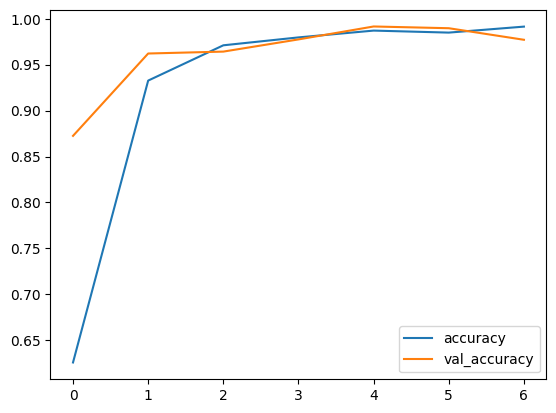

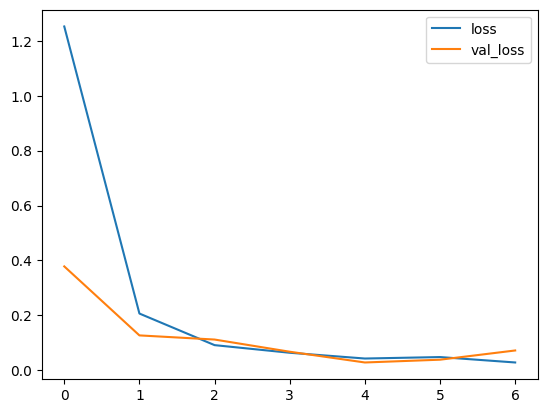

## Pooling layeer = avg pooling

,accuracy,val_accuracy,loss,val_loss
0,0.547624,0.816897,1.492352,0.548935
1,0.887682,0.928103,0.340871,0.222742
2,0.945728,0.964195,0.166355,0.117199
3,0.965498,0.941149,0.106965,0.169377
4,0.972548,0.950287,0.085685,0.145863


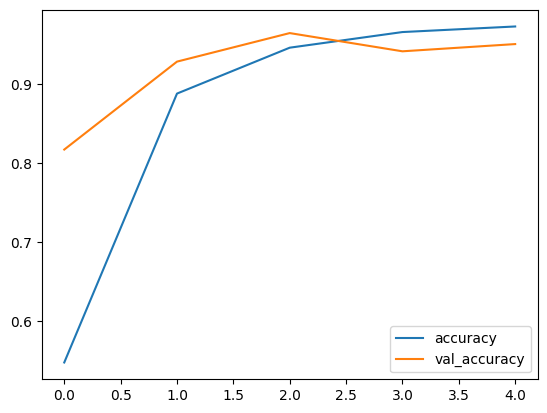

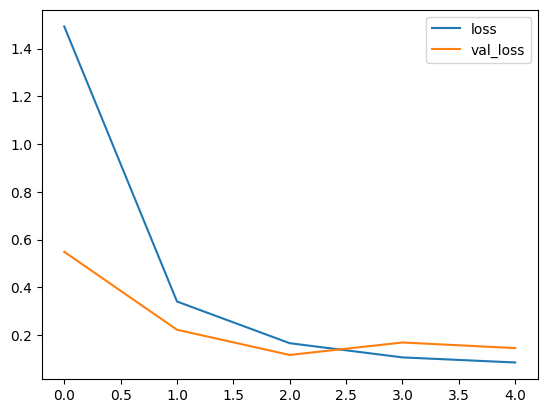

In [ ]:
display(Markdown("# Model metrics"))

for datum in model_data:

  model = datum['model']
  pooling_layer = datum['pooling_layer']
  metrics = datum['metrics']

  display(Markdown(f"## Pooling layeer = {pooling_layer}"))
  
  display(metrics[['accuracy', 'val_accuracy', 'loss', 'val_loss']])

  metrics[['accuracy','val_accuracy']].plot()
  plt.show()

  metrics[['loss','val_loss']].plot()
  plt.show()

### Display model prediction performance

# Model prediction performance

## Dense layers = max pooling

272/272 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       624
           1       0.97      1.00      0.98       609
           2       0.99      0.99      0.99       576
           3       0.96      1.00      0.98       580
           4       0.99      0.94      0.97       596
           5       1.00      0.99      1.00       597
           6       0.99      0.95      0.97       608
           7       0.98      1.00      0.99       588
           8       1.00      0.94      0.97       615
           9       1.00      0.96      0.98       614
          10       0.85      0.99      0.91       592
          11       1.00      0.99      0.99       623
          12       0.99      0.99      0.99       632
          13       0.99      1.00      0.99       579
          14       1.00      0.98      0.99       582
          15       0.99      0.98      0.99       601
          16       0.97   

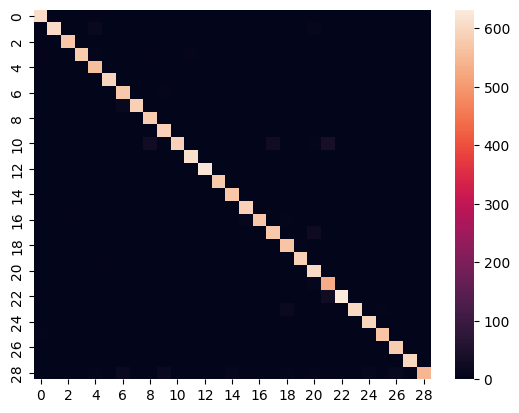

## Dense layers = avg pooling

272/272 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       624
           1       0.96      0.98      0.97       609
           2       1.00      0.99      0.99       576
           3       0.99      0.98      0.99       580
           4       0.93      0.92      0.93       596
           5       1.00      0.98      0.99       597
           6       0.98      0.98      0.98       608
           7       1.00      0.98      0.99       588
           8       1.00      0.83      0.90       615
           9       0.99      0.95      0.97       614
          10       0.97      0.94      0.96       592
          11       1.00      0.96      0.98       623
          12       0.96      0.90      0.93       632
          13       0.97      0.96      0.96       579
          14       0.96      0.98      0.97       582
          15       1.00      0.98      0.99       601
          16       0.98   

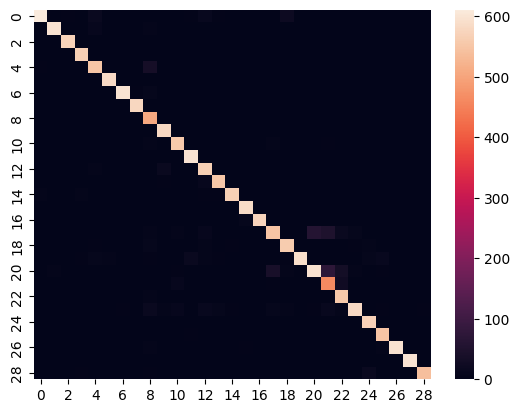

In [ ]:
display(Markdown("# Model prediction performance"))

predict_ds = test_ds

for datum in model_data:

  model = datum['model']
  pooling_layer = datum['pooling_layer']
  metrics = datum['metrics']

  display(Markdown(f"## Dense layers = {pooling_layer}"))

  y_pred_raw = model.predict(predict_ds)
  y_pred = np.argmax(y_pred_raw, axis=1)
  y_true = [y.numpy() for x, y in predict_ds.unbatch()]
  print(classification_report(y_true, y_pred))
  
  sns.heatmap(confusion_matrix(y_pred,y_true))
  plt.show()

## Saving models

**Optional:** uncomment below code block to save models to `models` folder.

In [ ]:
for datum in model_data:  
    datum['model'].save(f"models/{datum['pooling_layer']}_pooling_layer.h5")
    print(f"Model saved to: models/{datum['pooling_layer']}_pooling_layer.h5")

Model saved to: models/max pooling_pooling_layer.h5
Model saved to: models/avg pooling_pooling_layer.h5
